In [1]:
import openpathsampling as paths
from openpathsampling.tests.test_helpers import RandomMDEngine
import mdtraj as md
import numpy as np
import simtk.unit as u

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import psutil
import gc
import os

In [2]:
paths.netcdfplus.StorableObject.set_observer(True)

## Test for caching of storage

Create the template from a .pdb file

In [3]:
tmpl = paths.engines.openmm.tools.snapshot_from_pdb('../data/Alanine_solvated.pdb')

Create a fresh storage

In [4]:
st = paths.Storage('memtest.nc', template=tmpl, mode='w')

Set the caching mode to something that tries to cache only the very often used objects. It will actually remember the last 10 objects of each type and keep weak references to everything else.

In [5]:
st.set_caching_mode('memtest')

Create a random engine, which does only puts random numbers in the snapshots

In [6]:
engine = RandomMDEngine(template=tmpl)

Create 4 ensembles of different lengths (everything else does not make sense with random snapshots), and create a random shooter for these

In [7]:
ens_list = [paths.LengthEnsemble(l) for l in [5,10,15,20]]

In [8]:
shooter = paths.RandomChoiceMover([
        paths.OneWayShootingMover(ens, paths.UniformSelector(), engine=engine) for ens in ens_list
    ])

Generate an initial global state of 4 trajectories of the correct length

In [9]:
initial_state = paths.SampleSet([
    paths.Sample(
        replica = repid,
        trajectory = engine.generate(tmpl, [ens.can_append]),
        ensemble = ens
    )
    for repid, ens in enumerate(ens_list)
])

And check if all we did makes sense.

In [10]:
initial_state.consistency_check()

Create a simple simulator that will run the shooter from our initial state and store the results in the storage.

In [11]:
simulation = paths.PathSampling(
    storage = st,
    move_scheme = paths.LockedMoveScheme(shooter),
    globalstate = initial_state
)

Finally run the simulator and watch the change in cached elements

In [12]:
data = list()

In [13]:
disc = psutil.disk_usage('.').free
mem = psutil.virtual_memory().available
store_size = os.stat('memtest.nc').st_size

for i in range(500):    
    disc_old = disc
    mem_old = mem
    simulation.run(1)    
    disc = psutil.disk_usage('.').free
    mem = psutil.virtual_memory().available    
    store_size = os.stat('memtest.nc').st_size
    info = {            
            'disc' : (disc-disc_old) / 1024 / 10 ,
            'file' : store_size / 1024 / 100,
            'memory' : (mem-mem_old) / 1024 / 10,
            'objects' : paths.netcdfplus.StorableObject.count_weaks(),
            'object_count' : len(paths.netcdfplus.StorableObject._weak_cache)
        }
    image = st.cache_image()
    info.update({key: value for key, value in image['weak'].iteritems() if st.objects[key].cache.size[1] != 0})
    info['total'] = image['full']
    info['image'] = image
    data.append(info)

Working on Monte Carlo cycle number 500.

DONE! Completed 500 Monte Carlo cycles.



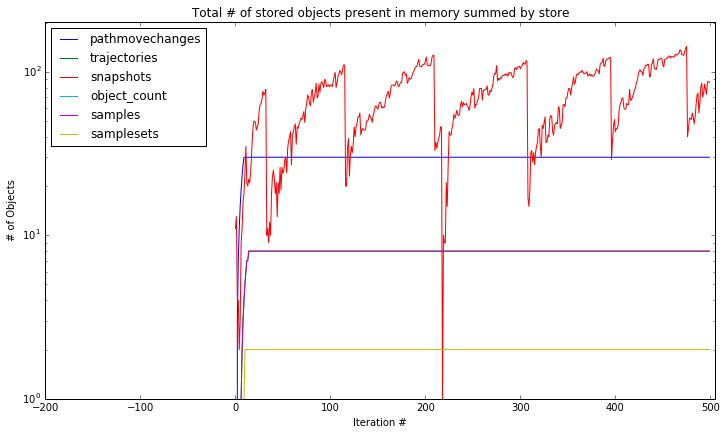

In [14]:
l = len(data)
dd = pd.DataFrame(data)
zero_names = [name for name in data[0] if len([q for q in data if q[name] != data[0][name]]) == 0]
ax = dd.plot(xlim=(-.4 * l,1.01 *l), ylim=(-1,201), figsize=(12,6.75), logy=True, y=
        [name for name in data[0] 
         if name in st.objects and not name in zero_names and name != 'image' or name == 'object_count'],
        title='Total # of stored objects present in memory summed by store')
ax.set_xlabel("Iteration #")
ax.set_ylabel("# of Objects")

ValueError: Data has no positive values, and therefore can not be log-scaled.

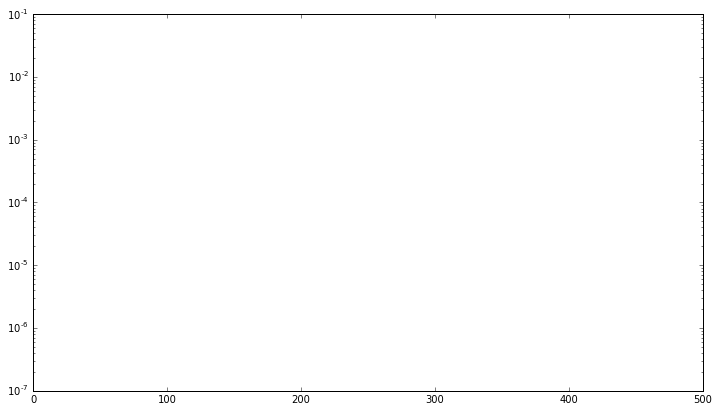

In [15]:
obj_data = [d['objects'] for d in data]
for n, d in enumerate(data):
    obj_data[n]['total'] = d['object_count']
l = len(obj_data)
dd2 = pd.DataFrame(obj_data)
# remove all columns that are strictly zero
zero_names = [name for name in obj_data[0] if name != 'total' and len([q for q in obj_data if q[name] != obj_data[0][name]]) == 0]
ax2 = dd2.plot(xlim=(-.4 * l,1.01 *l), ylim=(1,201), figsize=(12,6.75), logy=True, y=
        [name for name in obj_data[0] if not name in zero_names],
        title='Total # of objects in memory summed by base class (constant classes hidden)')
ax2.set_xlabel("Iteration #")
ax2.set_ylabel("# of Objects")

In [ ]:
tots = [d['image']['full'] for d in data]

This is a very crude test. We assume that the total number of referenced object in the last 100 steps is not larger than the maximum before. This would fails if in the loops we would store stuff and still keep hidden references to these objects. 

In [ ]:
tots = [d['object_count'] for d in data]
assert(max(tots[100:-100]) >= max(tots[-100:]))

What we do not check is if we keep hidden references to objects that we do not explicitely store in memory. This could be a big problem although it is not related to our storage. It merely means the we somewhere keep hidden references to objects that whould have been disposed of, since we do not store them.

In [ ]:
l = len(data)
dd.plot(xlim=(-.4 * l,1.01 *l), ylim=(-1000,1000), figsize=(12,6.75), 
        y=[name for name in data[0] if name in ['memory'] and name != 'image'])

In [ ]:
tots = [d['memory'] for d in data]
print 'Average memory consummation per step %f MB [middle]' % (sum(tots[100:-100])/len(tots[100:-100]) * 10. / 1024.)
print 'Average memory consummation per step %f MB [end]' % (sum(tots[-100:])/len(tots[-100:]) * 10. / 1024.)